In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F  # Import functional API for Leaky ReLU
import torch.optim as optim

torch.manual_seed(42)

In [2]:
# Parameters
nx = 400  # Number of spatial grid points
L = 5.0  # Length of the domain
dt = 0.01  # Time step
a = 0.8  # Advection speed
T = 5.0  # Total simulation time
nt = int(T / dt)  # Number of time steps
dx = L / (nx - 1)  # Spatial resolution

# Grid points
x = np.linspace(0, L, nx)
t = np.linspace(0, T, int(T/dt))

CFL = a * dt / dx
print(f"CFL Number: {CFL}")

# Initial condition: Gaussian pulse
def initial_condition(x):
    return np.exp(-((x - L / 4) / 0.1) ** 2)

CFL Number: 0.6384000000000001


In [3]:
# Define the neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(2, 64)  # Input: (x, t)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 64)
        self.fc6 = nn.Linear(64, 1)  # Output: u(x, t)

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)  # Concatenate x and t
        out = torch.sin(self.fc1(inputs))
        out = torch.sin(self.fc2(out))
        out = torch.sin(self.fc3(out))
        out = torch.sin(self.fc4(out))
        out = torch.sin(self.fc5(out))
        out = self.fc6(out)
        return out

# Initialize network and optimizer
model = NeuralNetwork()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define loss functions
def pde_loss(x, t, a):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    return torch.mean((u_t + a * u_x) ** 2)

def ic_loss(x):
    # Detach x and convert to NumPy for initial_condition
    x_np = x.detach().numpy()
    u_true = torch.tensor(initial_condition(x_np), dtype=torch.float32).reshape(-1, 1)
    u_pred = model(x, torch.zeros_like(x))  # Evaluate at t = 0
    return torch.mean((u_pred - u_true) ** 2)

def boundary_loss(t):
    # Sample points at the boundaries (x = 0 and x = L)
    x_left = torch.zeros_like(t)  # x = 0
    x_right = torch.full_like(t, L)  # x = L

    # Evaluate the model at the boundaries
    u_left = model(x_left, t)
    u_right = model(x_right, t)

    # Compute the mean squared error of the difference
    return torch.mean((u_left - u_right) ** 2)

# Training loop
for epoch in range(10000):
    optimizer.zero_grad()

    # Sample random collocation points
    num_samples = 100
    x_torch = torch.tensor(np.random.choice(x, num_samples, replace=True), dtype=torch.float32).reshape(-1, 1)
    t_torch = torch.tensor(np.random.choice(t, num_samples, replace=True), dtype=torch.float32).reshape(-1, 1)

    # Compute losses
    loss_pde = pde_loss(x_torch, t_torch, a)
    loss_ic = ic_loss(x_torch)
    loss_boundary = boundary_loss(t_torch)  # Add boundary loss
    loss = 3*loss_pde + loss_ic + loss_boundary  # Include boundary loss in total loss

    # Backpropagation
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, PDE Loss: {loss_pde.item()}, IC Loss: {loss_ic.item()}, Boundary Loss: {loss_boundary.item()}")

Epoch 0, Loss: 0.09157644212245941, PDE Loss: 0.0017762451898306608, IC Loss: 0.06999403238296509, Boundary Loss: 0.016253672540187836
Epoch 1000, Loss: 0.001975859049707651, PDE Loss: 0.00042525201570242643, IC Loss: 0.0006383651634678245, Boundary Loss: 6.173778092488647e-05
Epoch 2000, Loss: 0.00034274766221642494, PDE Loss: 0.00010496620234334841, IC Loss: 9.171260899165645e-06, Boundary Loss: 1.867779610620346e-05
Epoch 3000, Loss: 0.00018306236597709358, PDE Loss: 3.098258457612246e-05, IC Loss: 5.238195808487944e-05, Boundary Loss: 3.773264688788913e-05
Epoch 4000, Loss: 3.260099401813932e-05, PDE Loss: 3.0132139272609493e-06, IC Loss: 6.2074122979538515e-06, Boundary Loss: 1.7353939256281592e-05
Epoch 5000, Loss: 2.698185562621802e-05, PDE Loss: 3.897439000866143e-06, IC Loss: 5.160074124432867e-06, Boundary Loss: 1.0129463589692023e-05
Epoch 6000, Loss: 1.4973158613429405e-05, PDE Loss: 1.695163064141525e-06, IC Loss: 1.0086733936987002e-06, Boundary Loss: 8.878996595740318e-0

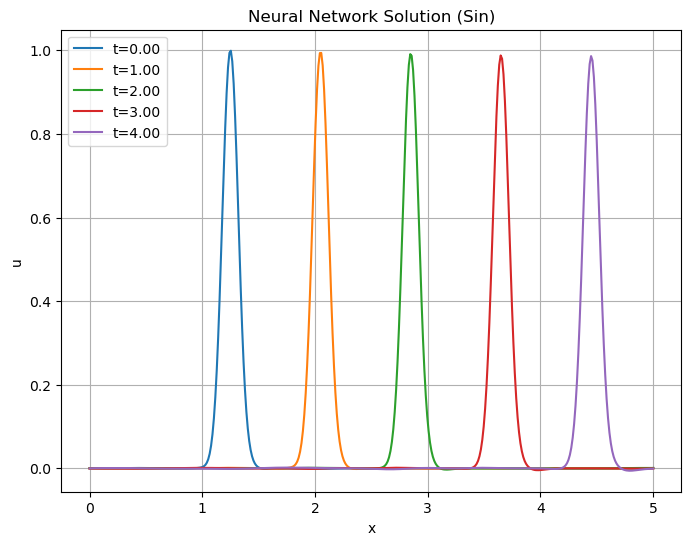

In [4]:
# Plot the results
plt.figure(figsize=(8, 6))
x_test = torch.tensor(x, dtype=torch.float32).reshape(-1, 1)

# Plot at specific time intervals
for n in range(5):
    t_test = torch.full_like(x_test, n) # Creates a vector with the same shape as x_test with a constant value equal to n
    with torch.no_grad(): 
        u_pred = model(x_test, t_test).detach().numpy()  # Detach tensor before converting to NumPy
    plt.plot(x, u_pred, label=f"t={n:.2f}")

plt.title('Neural Network Solution (Sin)')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid()
plt.savefig('plots/nn_sin.png')
plt.show()

In [5]:
# Define the neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(2, 64)  # Input: (x, t)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 64)
        self.fc6 = nn.Linear(64, 1)  # Output: u(x, t)

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)  # Concatenate x and t
        out = torch.tanh(self.fc1(inputs))
        out = torch.tanh(self.fc2(out))
        out = torch.tanh(self.fc3(out))
        out = torch.tanh(self.fc4(out))
        out = torch.tanh(self.fc5(out))
        out = self.fc6(out)
        return out

# Initialize network and optimizer
model = NeuralNetwork()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define loss functions
def pde_loss(x, t, a):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    return torch.mean((u_t + a * u_x) ** 2)

def ic_loss(x):
    # Detach x and convert to NumPy for initial_condition
    x_np = x.detach().numpy()
    u_true = torch.tensor(initial_condition(x_np), dtype=torch.float32).reshape(-1, 1)
    u_pred = model(x, torch.zeros_like(x))  # Evaluate at t = 0
    return torch.mean((u_pred - u_true) ** 2)

def boundary_loss(t):
    # Sample points at the boundaries (x = 0 and x = L)
    x_left = torch.zeros_like(t)  # x = 0
    x_right = torch.full_like(t, L)  # x = L

    # Evaluate the model at the boundaries
    u_left = model(x_left, t)
    u_right = model(x_right, t)

    # Compute the mean squared error of the difference
    return torch.mean((u_left - u_right) ** 2)

# Training loop
for epoch in range(10000):
    optimizer.zero_grad()

    # Sample random collocation points
    num_samples = 100
    x_torch = torch.tensor(np.random.choice(x, num_samples, replace=True), dtype=torch.float32).reshape(-1, 1)
    t_torch = torch.tensor(np.random.choice(t, num_samples, replace=True), dtype=torch.float32).reshape(-1, 1)

    # Compute losses
    loss_pde = pde_loss(x_torch, t_torch, a)
    loss_ic = ic_loss(x_torch)
    loss_boundary = boundary_loss(t_torch)  # Add boundary loss
    loss = 3*loss_pde + loss_ic + loss_boundary  # Include boundary loss in total loss

    # Backpropagation
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, PDE Loss: {loss_pde.item()}, IC Loss: {loss_ic.item()}, Boundary Loss: {loss_boundary.item()}")

Epoch 0, Loss: 0.0265373382717371, PDE Loss: 2.00286231120117e-05, IC Loss: 0.026429899036884308, Boundary Loss: 4.735423135571182e-05
Epoch 1000, Loss: 0.009083151817321777, PDE Loss: 0.0003803606959991157, IC Loss: 0.007034343667328358, Boundary Loss: 0.0009077267604880035
Epoch 2000, Loss: 0.002822490641847253, PDE Loss: 0.0007484522648155689, IC Loss: 0.0003962255723308772, Boundary Loss: 0.00018090820231009275
Epoch 3000, Loss: 0.001687500742264092, PDE Loss: 0.00034770212369039655, IC Loss: 0.0004873547295574099, Boundary Loss: 0.00015703959797974676
Epoch 4000, Loss: 0.0015086032217368484, PDE Loss: 7.154106424422935e-05, IC Loss: 0.000560527783818543, Boundary Loss: 0.0007334522670134902
Epoch 5000, Loss: 0.0012960569001734257, PDE Loss: 0.00016518926713615656, IC Loss: 0.00048473846982233226, Boundary Loss: 0.0003157505998387933
Epoch 6000, Loss: 0.0035784277133643627, PDE Loss: 0.0007106262492015958, IC Loss: 0.001050827675499022, Boundary Loss: 0.0003957214066758752
Epoch 70

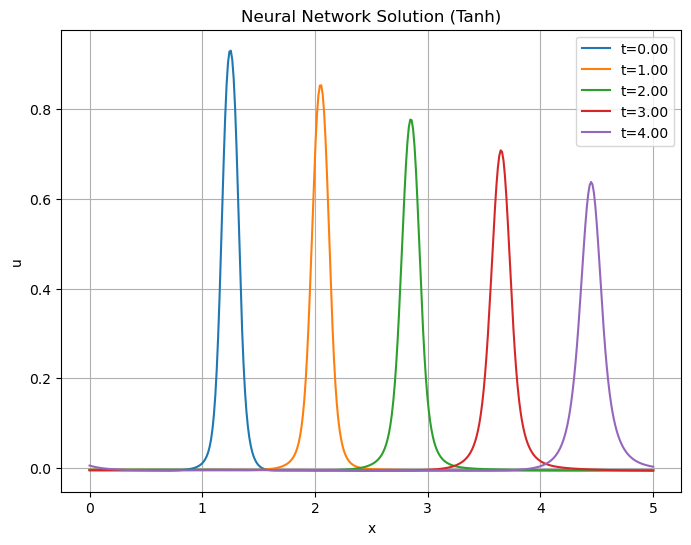

In [6]:
# Plot the results
plt.figure(figsize=(8, 6))
x_test = torch.tensor(x, dtype=torch.float32).reshape(-1, 1)

# Plot at specific time intervals
for n in range(5):
    t_test = torch.full_like(x_test, n) # Creates a vector with the same shape as x_test with a constant value equal to n
    with torch.no_grad(): 
        u_pred = model(x_test, t_test).detach().numpy()  # Detach tensor before converting to NumPy
    plt.plot(x, u_pred, label=f"t={n:.2f}")

plt.title('Neural Network Solution (Tanh)')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid()
plt.savefig('plots/nn_tanh.png')
plt.show()

In [7]:
# Define the neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(2, 64)  # Input: (x, t)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 64)
        self.fc6 = nn.Linear(64, 1)  # Output: u(x, t)

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)  # Concatenate x and t
        out = torch.relu(self.fc1(inputs))
        out = torch.relu(self.fc2(out))
        out = torch.relu(self.fc3(out))
        out = torch.relu(self.fc4(out))
        out = torch.real(self.fc5(out))
        out = self.fc6(out)
        return out

# Initialize network and optimizer
model = NeuralNetwork()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define loss functions
def pde_loss(x, t, a):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    return torch.mean((u_t + a * u_x) ** 2)

def ic_loss(x):
    # Detach x and convert to NumPy for initial_condition
    x_np = x.detach().numpy()
    u_true = torch.tensor(initial_condition(x_np), dtype=torch.float32).reshape(-1, 1)
    u_pred = model(x, torch.zeros_like(x))  # Evaluate at t = 0
    return torch.mean((u_pred - u_true) ** 2)

def boundary_loss(t):
    # Sample points at the boundaries (x = 0 and x = L)
    x_left = torch.zeros_like(t)  # x = 0
    x_right = torch.full_like(t, L)  # x = L

    # Evaluate the model at the boundaries
    u_left = model(x_left, t)
    u_right = model(x_right, t)

    # Compute the mean squared error of the difference
    return torch.mean((u_left - u_right) ** 2)

# Training loop
for epoch in range(10000):
    optimizer.zero_grad()

    # Sample random collocation points
    num_samples = 100
    x_torch = torch.tensor(np.random.choice(x, num_samples, replace=True), dtype=torch.float32).reshape(-1, 1)
    t_torch = torch.tensor(np.random.choice(t, num_samples, replace=True), dtype=torch.float32).reshape(-1, 1)

    # Compute losses
    loss_pde = pde_loss(x_torch, t_torch, a)
    loss_ic = ic_loss(x_torch)
    loss_boundary = boundary_loss(t_torch)  # Add boundary loss
    loss = 3*loss_pde + loss_ic + loss_boundary  # Include boundary loss in total loss

    # Backpropagation
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, PDE Loss: {loss_pde.item()}, IC Loss: {loss_ic.item()}, Boundary Loss: {loss_boundary.item()}")

Epoch 0, Loss: 0.07782724499702454, PDE Loss: 1.3791017408948392e-05, IC Loss: 0.07749684154987335, Boundary Loss: 0.0002890291507355869
Epoch 1000, Loss: 0.004212650470435619, PDE Loss: 0.0002419593947706744, IC Loss: 0.0005184289184398949, Boundary Loss: 0.0029683432076126337
Epoch 2000, Loss: 0.0023848507553339005, PDE Loss: 0.0003738703962881118, IC Loss: 0.0008543391595594585, Boundary Loss: 0.00040890046511776745
Epoch 3000, Loss: 0.0018147476948797703, PDE Loss: 0.0005338697228580713, IC Loss: 0.00011008432920789346, Boundary Loss: 0.00010305424075340852
Epoch 4000, Loss: 0.0013926398241892457, PDE Loss: 0.00034463804331608117, IC Loss: 0.00016774512187112123, Boundary Loss: 0.00019098045595455915
Epoch 5000, Loss: 0.004219639580696821, PDE Loss: 0.0002816169580910355, IC Loss: 0.0023781955242156982, Boundary Loss: 0.0009965932695195079
Epoch 6000, Loss: 0.0012182920472696424, PDE Loss: 0.000310551404254511, IC Loss: 4.7456494939979166e-05, Boundary Loss: 0.00023918137594591826


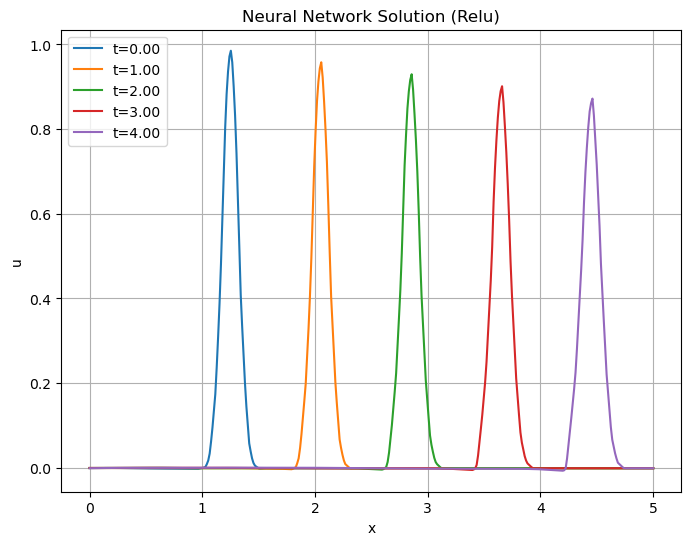

In [8]:
# Plot the results
plt.figure(figsize=(8, 6))
x_test = torch.tensor(x, dtype=torch.float32).reshape(-1, 1)

# Plot at specific time intervals
for n in range(5):
    t_test = torch.full_like(x_test, n) # Creates a vector with the same shape as x_test with a constant value equal to n
    with torch.no_grad(): 
        u_pred = model(x_test, t_test).detach().numpy()  # Detach tensor before converting to NumPy
    plt.plot(x, u_pred, label=f"t={n:.2f}")

plt.title('Neural Network Solution (Relu)')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid()
plt.savefig('plots/nn_relu.png')
plt.show()

In [9]:
# Define the neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(2, 64)  # Input: (x, t)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 64)
        self.fc6 = nn.Linear(64, 1)  # Output: u(x, t)

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)  # Concatenate x and t
        out = torch.sigmoid(self.fc1(inputs))
        out = torch.sigmoid(self.fc2(out))
        out = torch.sigmoid(self.fc3(out))
        out = torch.sigmoid(self.fc4(out))
        out = torch.sigmoid(self.fc5(out))
        out = self.fc6(out)
        return out

# Initialize network and optimizer
model = NeuralNetwork()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define loss functions
def pde_loss(x, t, a):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    return torch.mean((u_t + a * u_x) ** 2)

def ic_loss(x):
    # Detach x and convert to NumPy for initial_condition
    x_np = x.detach().numpy()
    u_true = torch.tensor(initial_condition(x_np), dtype=torch.float32).reshape(-1, 1)
    u_pred = model(x, torch.zeros_like(x))  # Evaluate at t = 0
    return torch.mean((u_pred - u_true) ** 2)

def boundary_loss(t):
    # Sample points at the boundaries (x = 0 and x = L)
    x_left = torch.zeros_like(t)  # x = 0
    x_right = torch.full_like(t, L)  # x = L

    # Evaluate the model at the boundaries
    u_left = model(x_left, t)
    u_right = model(x_right, t)

    # Compute the mean squared error of the difference
    return torch.mean((u_left - u_right) ** 2)

# Training loop
for epoch in range(10000):
    optimizer.zero_grad()

    # Sample random collocation points
    num_samples = 100
    x_torch = torch.tensor(np.random.choice(x, num_samples, replace=True), dtype=torch.float32).reshape(-1, 1)
    t_torch = torch.tensor(np.random.choice(t, num_samples, replace=True), dtype=torch.float32).reshape(-1, 1)

    # Compute losses
    loss_pde = pde_loss(x_torch, t_torch, a)
    loss_ic = ic_loss(x_torch)
    loss_boundary = boundary_loss(t_torch)  # Add boundary loss
    loss = 3*loss_pde + loss_ic + loss_boundary  # Include boundary loss in total loss

    # Backpropagation
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, PDE Loss: {loss_pde.item()}, IC Loss: {loss_ic.item()}, Boundary Loss: {loss_boundary.item()}")

Epoch 0, Loss: 0.0696650892496109, PDE Loss: 3.290542560652199e-10, IC Loss: 0.0696650817990303, Boundary Loss: 4.081502247288427e-09
Epoch 1000, Loss: 0.014476948417723179, PDE Loss: 3.915714114555158e-05, IC Loss: 0.014096182771027088, Boundary Loss: 0.0002632937685120851
Epoch 2000, Loss: 0.005064662545919418, PDE Loss: 0.0011612361995503306, IC Loss: 0.0014985348097980022, Boundary Loss: 8.241947944043204e-05
Epoch 3000, Loss: 0.006643568631261587, PDE Loss: 0.001910582883283496, IC Loss: 0.0007183294510468841, Boundary Loss: 0.00019349083595443517
Epoch 4000, Loss: 0.004408025182783604, PDE Loss: 0.001284497557207942, IC Loss: 0.0003309031599201262, Boundary Loss: 0.00022362923482432961
Epoch 5000, Loss: 0.0012224395759403706, PDE Loss: 0.0002544368617236614, IC Loss: 0.00034355680691078305, Boundary Loss: 0.00011557218385860324
Epoch 6000, Loss: 0.002487805439159274, PDE Loss: 0.0007305369363166392, IC Loss: 0.000141072494443506, Boundary Loss: 0.00015512197569478303
Epoch 7000, 

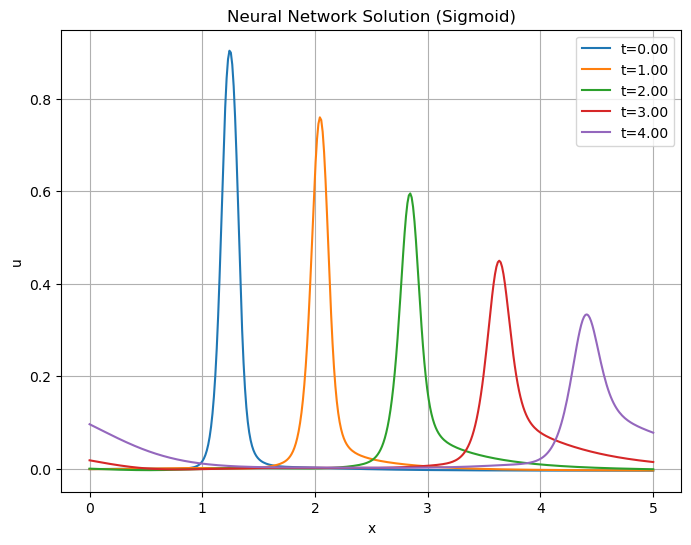

In [10]:
# Plot the results
plt.figure(figsize=(8, 6))
x_test = torch.tensor(x, dtype=torch.float32).reshape(-1, 1)

# Plot at specific time intervals
for n in range(5):
    t_test = torch.full_like(x_test, n) # Creates a vector with the same shape as x_test with a constant value equal to n
    with torch.no_grad(): 
        u_pred = model(x_test, t_test).detach().numpy()  # Detach tensor before converting to NumPy
    plt.plot(x, u_pred, label=f"t={n:.2f}")

plt.title('Neural Network Solution (Sigmoid)')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid()
plt.savefig('plots/nn_sigmoid.png')
plt.show()